In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from math import sqrt
from catboost import CatBoostRegressor

D:\AnacondaNavigator\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [130]:
df = pd.read_csv(r'C:/Users/Venom/Desktop/694560_1215964_bundle_archive/preprocessed_data.csv')

In [131]:
df['Date'] = pd.to_datetime(df['Date'])

In [132]:
def train_test_split(data,column,train_start_date, train_end_date,test_start_date,test_end_date):
    train_start_date = pd.to_datetime(train_start_date)
    train_end_date =  pd.to_datetime(train_end_date)
    test_start_date =  pd.to_datetime(test_start_date)
    test_end_date = pd.to_datetime(test_end_date)
    data[column] = pd.to_datetime(data[column])
    train = data.loc[(data[column]>=train_start_date)&(data[column]<=train_end_date)]
    test = data.loc[(data[column]>=test_start_date)&(data[column]<=test_end_date)]
    train.reset_index(drop =True,inplace = True)
    test.reset_index(drop =True,inplace = True)
    return train,test

In [133]:
df.Region.unique()

array(['Africa', 'Asia', 'North America', 'Middle East', 'Europe',
       'South/Central America & Carribean', 'Australia/South Pacific'],
      dtype=object)

In [134]:
df_europe = df[df.Region=='Europe']
df_europe.shape

(361973, 12)

In [135]:
df_na = df[df.Region=='North America']
df_na.shape

(1508776, 12)

In [136]:
df_au = df[df.Region=='Australia/South Pacific']
df_au.shape

(54405, 12)

In [137]:
df_asia = df[df.Region=='Asia']
df_asia.shape

(301754, 12)

In [138]:
df_sa = df[df.Region=='South/Central America & Carribean']
df_sa.shape

(194968, 12)

In [139]:
df_me_af =  df[(df.Region=='Middle East')|(df.Region=='Africa')]
df_me_af.shape

(336924, 12)

In [140]:
df.shape[0]==(df_europe.shape[0]+df_na.shape[0]+df_au.shape[0]+df_asia.shape[0]+df_sa.shape[0]+df_me_af.shape[0])

True

#### Europe model

In [141]:
df_europe['prev_day'] = df_europe.groupby('City').AvgTemperature.shift(1)
df_europe['prev_year'] = df_europe.groupby('City').AvgTemperature.shift(365)
df_europe['prev_2year'] = df_europe.groupby('City').AvgTemperature.shift(365*2)
df_europe['prev_3year'] = df_europe.groupby('City').AvgTemperature.shift(365*3)

D:\AnacondaNavigator\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
D:\AnacondaNavigator\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\AnacondaNavigator\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [238]:
x_train,x_test = train_test_split(df_europe.copy(),'Date','1995-01-01','2018-09-02','2019-12-24','2019-12-31')

In [239]:
x_test.Date.max()-x_test.Date.min()

Timedelta('7 days 00:00:00')

In [240]:
country_temp_mapper =  x_train.groupby('Country').AvgTemperature.mean().to_dict()
city_temp_mapper =  x_train.groupby('City').AvgTemperature.mean().to_dict()

In [241]:
x_train['Country_enc'] = x_train['Country'].map(country_temp_mapper)
x_test['Country_enc'] = x_test['Country'].map(country_temp_mapper)

x_train['City_enc'] = x_train['City'].map(city_temp_mapper)
x_test['City_enc'] = x_test['City'].map(city_temp_mapper)

In [242]:
'''x_train['combined'] = x_train.Country.astype(str)+"_"+x_train.Month.astype(str)
country_month_details = x_train.groupby(['combined']).AvgTemperature.mean().to_dict()
x_train['country_month_mean'] = x_train.combined.map(country_month_details)

x_test['combined'] = x_test.Country.astype(str)+"_"+x_test.Month.astype(str)
x_test['country_month_mean'] = x_test.combined.map(country_month_details)'''

###################################################################################################

x_train['combined'] = x_train.City.astype(str)+"_"+x_train.Month.astype(str)
city_month_details = x_train.groupby(['combined']).AvgTemperature.mean().to_dict()
x_train['city_month_mean'] = x_train.combined.map(city_month_details)

x_test['combined'] = x_test.City.astype(str)+"_"+x_test.Month.astype(str)
x_test['city_month_mean'] = x_test.combined.map(city_month_details)


In [243]:
x_train.drop('combined',inplace=True,axis = 1)
x_test.drop('combined',inplace=True,axis = 1)

In [244]:
y_train = x_train.AvgTemperature
y_test = x_test.AvgTemperature

In [245]:
selected = ['Month',
       'prev_day', 'prev_year','prev_2year','prev_3year', 'City_enc','city_month_mean']
len(selected)

7

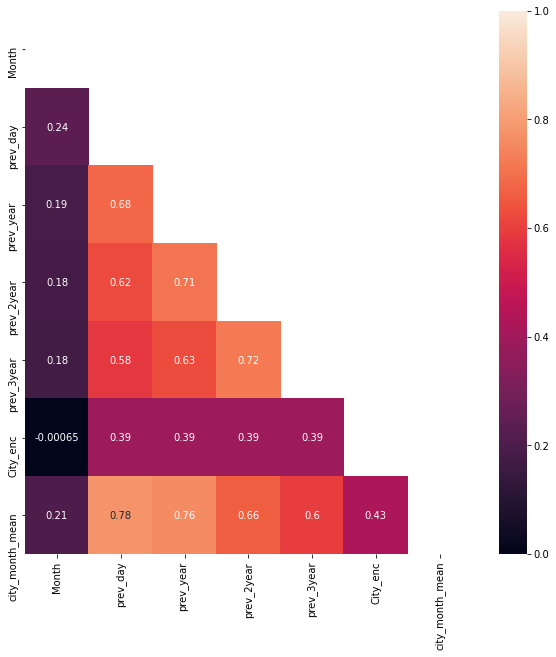

In [246]:
plt.figure(figsize=(10,10))
matrix = np.triu(x_train[selected].corr())
sns.heatmap(x_train[selected].corr(), annot=True, mask=matrix)

RMSE :  4.291213374150844


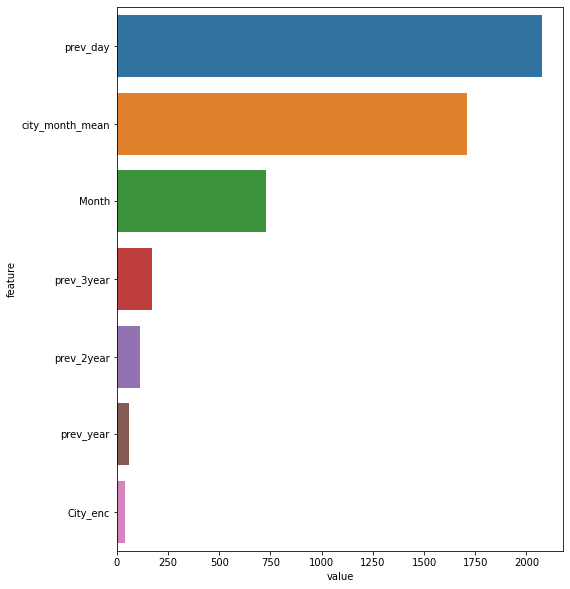

In [247]:
model = lgb.LGBMRegressor(n_estimators=700, max_depth=3,learning_rate=0.008)
model.fit(x_train[selected],y_train)
feat_importance = pd.DataFrame()
feat_importance["feature"] = selected
feat_importance["value"] = model.feature_importances_
feat_importance.sort_values(by='value', ascending=False, inplace=True)

plt.figure(figsize=(8,10))
ax = sns.barplot(y="feature", x="value", data=feat_importance)
pred = model.predict(x_test[selected])
rmse = sqrt(mean_squared_error(y_test, pred))
print("RMSE : ",rmse)
result_europe = pd.DataFrame()
result_europe = x_test
result_europe['actual'] = y_test
result_europe['predicted'] = pred

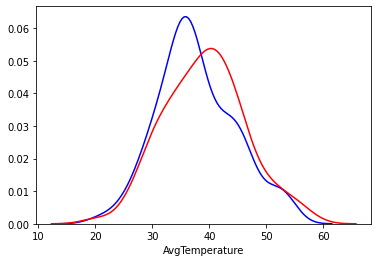

In [248]:
sns.distplot(pred, hist=False,color='b')
sns.distplot(y_test, hist=False,color='r')

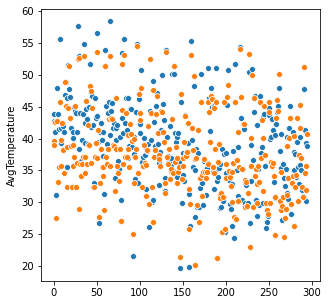

In [249]:
plt.figure(figsize=(5,5))
sns.scatterplot(np.arange(y_test.shape[0]),y_test)
sns.scatterplot(np.arange(y_test.shape[0]),pred)

In [250]:
result_europe['error'] = np.abs(result_europe.actual-result_europe.predicted)
print("SPOT ON % : ",result_europe[result_europe.predicted.astype(int)==result_europe.actual.astype(int)].shape[0]/result_europe.shape[0]*100)
print("+-3 % : ",result_europe[result_europe.error<=3].shape[0]/result_europe.shape[0]*100)
print("+-7 % : ",result_europe[result_europe.error<=7].shape[0]/result_europe.shape[0]*100)
print("+-10 % : ",result_europe[result_europe.error<=10].shape[0]/result_europe.shape[0]*100)

SPOT ON % :  9.121621621621621
+-3 % :  52.36486486486487
+-7 % :  89.1891891891892
+-10 % :  97.63513513513513


#### North America Model

In [237]:
df_na['prev_day'] = df_na.groupby('City').AvgTemperature.shift(1)
df_na['prev_year'] = df_na.groupby('City').AvgTemperature.shift(365)
df_na['prev_2year'] = df_na.groupby('City').AvgTemperature.shift(365*2)
df_na['prev_3year'] = df_na.groupby('City').AvgTemperature.shift(365*3)

D:\AnacondaNavigator\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
D:\AnacondaNavigator\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\AnacondaNavigator\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [251]:
x_train,x_test = train_test_split(df_na.copy(),'Date','1995-01-01','2018-09-02','2019-12-24','2019-12-31')

In [252]:
country_temp_mapper =  x_train.groupby('Country').AvgTemperature.mean().to_dict()
city_temp_mapper =  x_train.groupby('City').AvgTemperature.mean().to_dict()

In [253]:
x_train['Country_enc'] = x_train['Country'].map(country_temp_mapper)
x_test['Country_enc'] = x_test['Country'].map(country_temp_mapper)

x_train['City_enc'] = x_train['City'].map(city_temp_mapper)
x_test['City_enc'] = x_test['City'].map(city_temp_mapper)

In [254]:
x_train['combined'] = x_train.City.astype(str)+"_"+x_train.Month.astype(str)
city_month_details = x_train.groupby(['combined']).AvgTemperature.mean().to_dict()
x_train['city_month_mean'] = x_train.combined.map(city_month_details)

x_test['combined'] = x_test.City.astype(str)+"_"+x_test.Month.astype(str)
x_test['city_month_mean'] = x_test.combined.map(city_month_details)

In [255]:
x_train.drop('combined',inplace=True,axis = 1)
x_test.drop('combined',inplace=True,axis = 1)

In [256]:
y_train = x_train.AvgTemperature
y_test = x_test.AvgTemperature

In [257]:
selected = ['Month',
       'prev_day', 'prev_year','prev_2year','prev_3year', 'City_enc','city_month_mean']
len(selected)

7

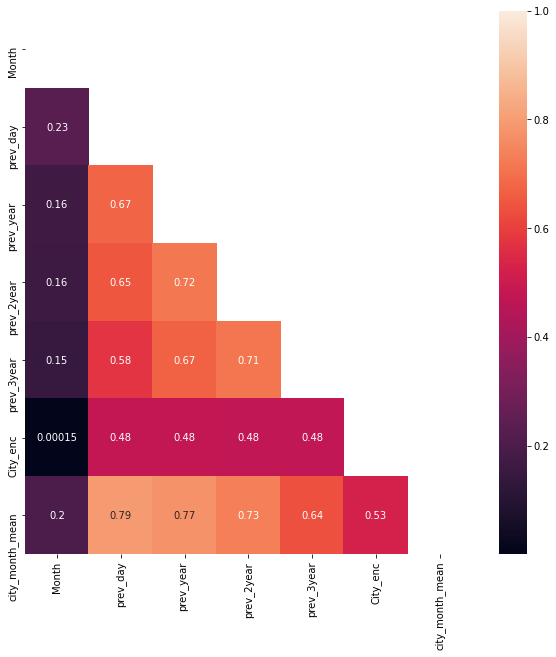

In [258]:
plt.figure(figsize=(10,10))
matrix = np.triu(x_train[selected].corr())
sns.heatmap(x_train[selected].corr(), annot=True, mask=matrix)

RMSE :  7.651209263868714


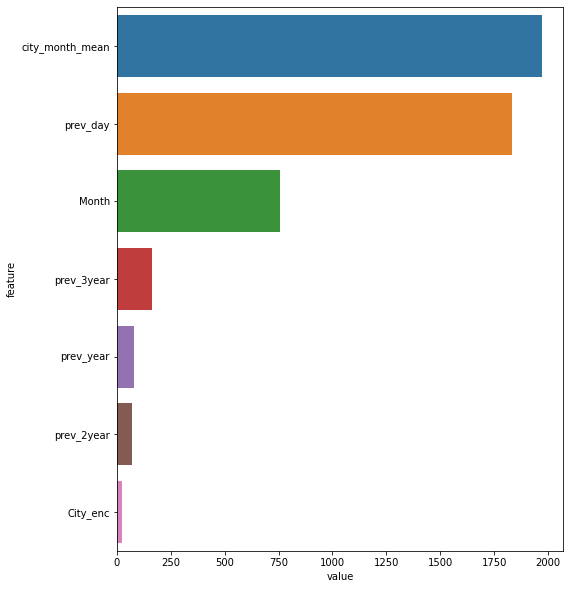

In [259]:
model = lgb.LGBMRegressor(n_estimators=700, max_depth=3,learning_rate=0.008)
model.fit(x_train[selected],y_train)
feat_importance = pd.DataFrame()
feat_importance["feature"] = selected
feat_importance["value"] = model.feature_importances_
feat_importance.sort_values(by='value', ascending=False, inplace=True)

plt.figure(figsize=(8,10))
ax = sns.barplot(y="feature", x="value", data=feat_importance)
pred = model.predict(x_test[selected])
rmse = sqrt(mean_squared_error(y_test, pred))
print("RMSE : ",rmse)
result_europe = pd.DataFrame()
result_europe = x_test
result_europe['actual'] = y_test
result_europe['predicted'] = pred

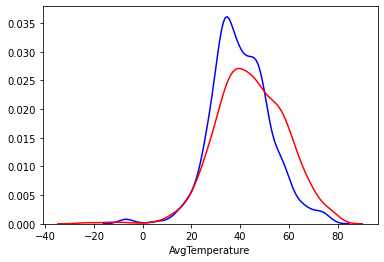

In [260]:
sns.distplot(pred, hist=False,color='b')
sns.distplot(y_test, hist=False,color='r')

In [ ]:
plt.figure(figsize=(5,5))
sns.scatterplot(np.arange(y_test.shape[0]),y_test)
sns.scatterplot(np.arange(y_test.shape[0]),pred)